In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

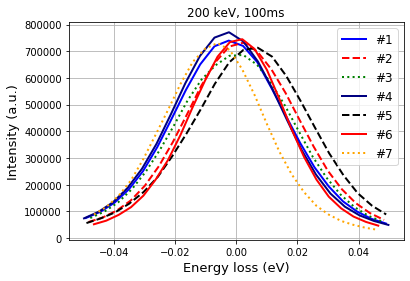

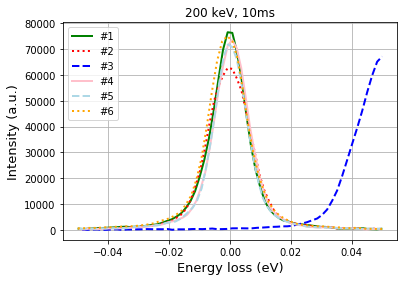


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 7


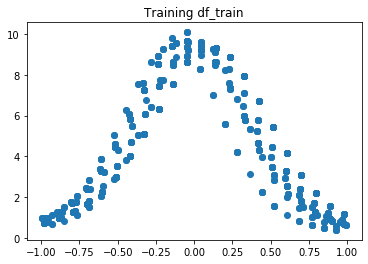

In [108]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py

seed = seednumber


### Find uncertainties on data

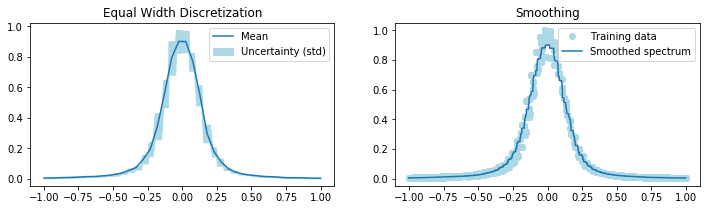

The total number of training datapoints is 2282 and validation points is 978


In [109]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

nbins = 40
minval = -1
maxval = +1

x_train_, y_train, x_val, y_val = prepare_mix_data(10)


# Create a plot of the mean & std 
plt.subplot(1, 2, 1)
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.title('Equal Width Discretization')
fig.set_size_inches(12, 5)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]


# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


### Apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 200))
smooth_y_test = np.array(smooth(df_val[:,1], 200))

plt.subplot(1,2,2)
plt.plot(df_train[:,0], df_train[:,1], 'o', color='lightblue', label='Training data')
plt.plot(df_train[:,0], smooth_y, label='Smoothed spectrum')
fig.set_size_inches(12,3)
plt.title('Smoothing')
plt.legend()
plt.show()

print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Neural Network 

### Create architecture

In [110]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.1)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Shape of this round of Monte Carlo replicas is: (2282, 1)
Example of one training x, shape (,2): [-0.93266699  1.        ]
Example of one training y, shape (,1): [0.00628642]
Start training on 2282 and validating on 0978 samples
Epoch: 0001 | Training cost= 18275.685546875 | Validation cost= 19356.441406250
Epoch: 1001 | Training cost= 28.826574326 | Validation cost= 45.857757568
Epoch: 2001 | Training cost= 28.470081329 | Validation cost= 45.486095428
Epoch: 3001 | Training cost= 27.450099945 | Validation cost= 44.410541534
Epoch: 4001 | Training cost= 22.351318359 | Validation cost= 39.047813416
Epoch: 5001 | Training cost= 20.851099014 | Validation cost= 37.481468201
Epoch: 6001 | Training cost= 20.511756897 | Validation cost= 36.921520233
Epoch: 7001 | Training cost= 19.433622360 | Validation cost= 35.458133698
Epoch: 8001 | Training cost= 16.708339691 | Validation cost= 31.651491165
Epoch: 9001 | Training cost= 14.271108627 | Validation cost= 28.631877899
Epoch: 10001 | Training c

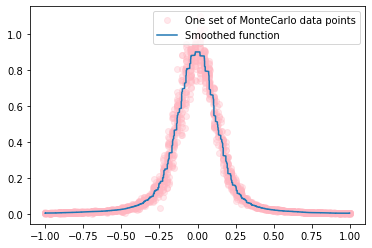

In [137]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

train_x = add_time(df_train, 10)
#train_x = df_train[:,0].reshape(N_train,1)
train_y = copy(smooth_y).reshape(N_train,1)  ## train_y = smooth_y in case of smoothing
train_sigma = df_train[:,2].reshape(N_train,1)
train_y = train_y + np.random.normal(0, train_sigma) # Create one replica of the training set
print("Shape of this round of Monte Carlo replicas is:", train_y.shape)

test_x = add_time(df_val, 10)
#test_x = df_val[:,0].reshape(N_test,1)
test_y = smooth_y_test.reshape(N_test,1)
test_sigma = df_val[:,2].reshape(N_test,1)
test_y +=   np.random.normal(0, test_sigma) # Create Monte Carlo points

predictions = make_model(x,1)

    ### Define cost and optimizer

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 2e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

plt.plot(df_train[:,0], train_y, 'o', alpha=.3, color='lightpink', label='One set of MonteCarlo data points')
plt.plot(df_train[:,0], smooth_y, label='Smoothed function')
plt.legend()
plt.show

print("Example of one training x, shape (,2):", train_x[80,:])
print("Example of one training y, shape (,1):", train_y[80])

# Scaling input features to help the minimizer.
train_scaler = StandardScaler()
train_scaler.fit(train_x[:,0].reshape(1,-1))
test_scaler = StandardScaler()
test_scaler.fit(test_x[:,0].reshape(1,-1))

### Train and validate

training_epochs = 30000
max_rising_epochs = 20000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
prev_test_cost = 100
prev_epoch=0
avg_cost = 0.0

predict_xx = np.linspace(-1.5, 1.5, N_train)
predict_x = np.c_[predict_xx, 0*predict_xx+1]

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x,
                            y: train_y,
                            sigma: train_sigma
                        })
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
        
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: predict_x,
                            y: train_y 
                        })
sess.close()
    
# save to csv file
from datetime import datetime
predictions_values = predictions_values.reshape(N_train,)

#foot = np.array(seednumber)
a = np.array(train_x[:,0])
b = np.array(train_y)
c = np.array(predictions_values)
d = array_train
e = array_test

seed = seednumber

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
#np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
#np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')



### Plot outputs

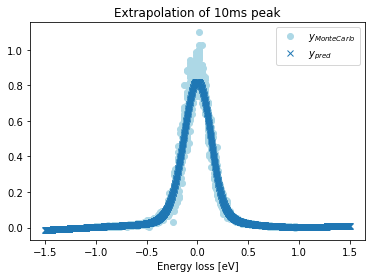

In [143]:
plt.plot(train_x[:,0], train_y, 'o', label='$y_{MonteCarlo}$', color='lightblue')
plt.plot(predict_x[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
plt.xlabel(r'Energy loss [eV]')

plt.title('Extrapolation of 10ms peak')
plt.savefig('Figures/Extrapolation')
plt.show()

[0.07757807 0.13855954 0.22380437 0.36652111 0.38751655 0.21389341
 0.27045996 0.31467838 0.09666703 0.07456951 0.06377543 0.08370427
 0.35689056 0.27683277 0.20294311 0.3227749  0.30902219 0.1886162
 0.08683981 0.06217734]


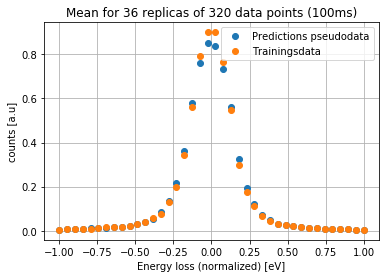

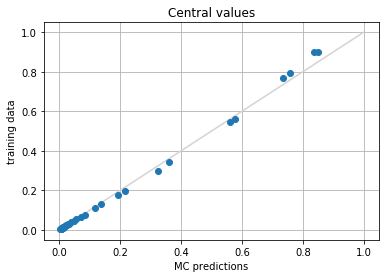

In [126]:
%run Evaluate_pseudodata.ipynb

#plt.plot(train_x, train_y,'o')
#plt.plot(pseudo_x, pseudo_pred, 'x', color='lightblue', label='Predictions')
plt.title('Mean for 36 replicas of 320 data points (100ms)')
pseudo_meanvector = np.linspace(-1,1,40)
plt.plot(pseudo_meanvector, pseudo10_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo10_mean, mean_t, 'o')
plt.title('Central values')
plt.show()

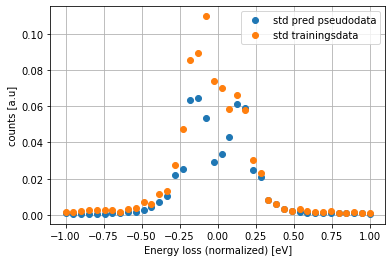

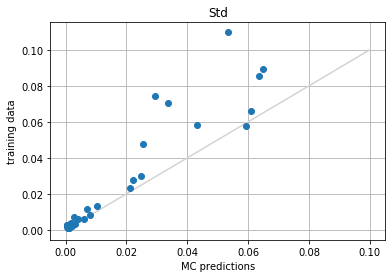

In [128]:
plt.plot(pseudo_meanvector, pseudo10_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 40), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.plot(pseudo10_std, std_t, 'o')
plt.title('Std')
plt.show()